# Conway's *Game of Life* with a Convolutional Neural Network (CNN)


Here we build a CNN that can be used to calculate iterations in Conway's *Game of Life*.

## Import necessary modules for this notebook

In [1]:
# display the versions of Jupyther and Python
print('Jupyter ', end='')
!jupyter --version
!python --version

# import Numpy and show its version
import numpy as np
np.random.seed(27)
print('Numpy version', np.version.version)

# import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# import timing functionality
import time

# import Keras and show its version and backend
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, ZeroPadding2D
print('Keras version {} using "{}" backend'.format(
    keras.__version__, keras.backend.backend())
    )

Jupyter 4.1.0
Python 3.5.2
Numpy version 1.14.2
Keras version 2.1.5 using "tensorflow" backend


## Conway's *Game of Life*
[Conway's *Game of Life*](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) is a cellular automaton devised by the British mathematician John Conway in 1970. The game takes place on a 2-dimensional grid of cells, where each cell can be either dead or alive.

After the cells in a grid are given an initial value (called a *seed*), the state of each cell of the grid in a subsequent time step (called a *tick*) is defined according to the following rules:
0. Any live cell with fewer than two live neighbors dies, as if caused by underpopulation.
0. Any live cell with two or three live neighbors lives on to the next generation.
0. Any live cell with more than three live neighbors dies, as if by overpopulation.
0. Any dead cell with exactly three live neighbors becomes a live cell, as if by reproduction.

## Why a CNN?
CNNs are typically used for image processing. A CNN is a type of neural network that includes at least one convolutional layer. In a convolutional layer, a convolutional filter is applied to the input (e.g. a 2-dimensional image). The filter can be thought of as a window (or *kernel*) that slides over the input, each time computing the same function on the pixels covered by the window, resulting in a singular value for each window position. Typically the value is the summation of the element-wise multiplication of the filter and the covered pixels (potentially adding a bias term), to which a (potentially non-linear) activation function can then be applied.

Since a rule-based calculation of the next iteration in a game of life also (implicitly) requires a sort of sliding window to go over the grid (since for each cell all of its neighbours have to be inspected), I thought it would be an interesting exercise to see if a CNN might be employed to implement the same function, how compact such a CNN could be, and if its weights are deducible or otherwise understandable. Perhaps exploring these questions can broaden the understanding of cellullar automata like Conway's *Game of Life*.

## Designing the CNN

### Grid representation

We will represent the grid as an array of integers, where each cell can take on the value $0$ or $1$, corresponding respectively to alive and dead. This representation will allow us to easily add the values of neighbouring cells to get the amount of live neighbours. It is also a convenient representation to use with CNNs, which operate on numerical matrices.

### Conway's rules

Conway's rules apply to a cell with its neighbours, so to a $3 \times 3$ block of integers in our representation. They can be expressed by the boolean expression $(c = 0 \wedge n = 3) \vee (c = 1 \wedge (n = 2 \vee n = 3))$, where $c$ denotes the value of the center cell and $n$ denotes the number of live neighbours (where it is noteworthy that $c$ and $n$ can each be straightforwardly computed from an input block by two linear $3 \times 3$ convolutions).
In our grid representation, its evaluation is mapped to integers as $false \rightarrow 0$ and $true \rightarrow 1$. The boolean expression can be further reduced:

$$
\def\widevee{\;\vee\;}
\def\widewedge{\;\wedge\;}
\let\nor\downarrow
\def\widenor{\;\nor\;}
\def\relu{\operatorname{ReLU}}
\def\rewrite#1#2{\equiv\text{\{#1\}}\\#2}
\begin{array}{c}
(c = 0 \widewedge n = 3) \widevee (c = 1 \widewedge (n = 2 \widevee n = 3))\\
\rewrite{$\wedge$ distributes over $\vee$}{(c = 0 \widewedge n = 3) \widevee (c = 1 \widewedge n = 2) \widevee (c = 1 \widewedge n = 3)}\\
\rewrite{duplicate first disjunction and reorder}{
  \begin{array}[t]{c}
  (c = 0 \widewedge n = 3) \widevee (c = 1 \widewedge n = 2)\\
  \rewrite{$c \in \{0,1\}$ and $n \in \{0, \dots, 8\}$}{c + n = 3}
  \end{array}
  \quad \vee \quad
  \begin{array}[t]{c}
  (c = 0 \widewedge n = 3) \widevee (c = 1 \widewedge n = 3)\\
  \rewrite{$\wedge$ distributes over $\vee$}{(c = 0 \widevee c = 1) \widewedge n = 3}\\
  \rewrite{$c \in \{0,1\}$}{n = 3}
  \end{array}
  }\\
\rewrite{collect terms}{c + n - 3 = 0 \widevee n - 3 = 0}
\;.
\end{array}
$$

These two terms can also be straightforwardly computed from an input block with by two linear $3 \times 3$ convolutions with a bias. But we need to be able to implement the comparison to zero and the logical or.

### Boolean mapping, the Rectified Linear Unit (ReLU), and numerical inequality checks

We need a conceptual way to map the activation values in a neural network to booleans, if we want to successfully reason about evaluating the aforementioned boolean expression in a neural network. We can map numerical values to booleans in the same way that the C&nbsp;programming language does (i.e.&nbsp;a zero value corresponds to $false$ and a non-zero value corresponds to $true$). For this particular problem instance, it turns out we need only to consider integers, therefore our mapping is:

$$
\begin{array}{rcl}
0 & \equiv & false\\
\text{any } i \in \mathbb{Z} \setminus \{0\} & \equiv & true
\;.
\end{array}
$$

Next, we need to be able to perform numerical checks. In order to do these, we can actually make use of the [rectified linear](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation function. A unit (or neuron) in a neural network with the rectified linear activation function is referred to as a Rectified Linear Unit (ReLU), which has become the dominant choice of unit in deep neural networks, in the past years. The rectified linear function is defined as:

$$
\begin{array}{c}
\relu(x) = \max(0, x)
\;.
\end{array}
$$

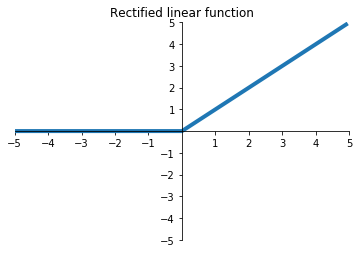

In [2]:
# initialize a new figure
fig, ax = plt.subplots()
# plot the rectified linear function from [-5, 5]
x = np.arange(-5, 5, 0.1)
relu_x = np.maximum(0, x)
ax.plot(x, relu_x, linewidth=4)
ax.set_title('Rectified linear function')
# configure axes and range of the plot
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xticks([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
ax.set_yticks([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
# show the figure
plt.show()

What can we do with ReLUs? Well, given certain restrictions to the possible input values, we can implement basic logical operators like *and*, *negation*, and *or* using only single ReLUs (with $\mathbb{N}_0$ denoting the set of natural numbers including $0$): ![ReLU implementations of logical and, logical not, logical or.](img/logical-and-not-or.svg).

Unfortunately, the necessary input restrictions for the *logical and* and *negation* are quite limiting, leaving us with a [functionally complete](https://en.wikipedia.org/wiki/Functional_completeness) set of logical operator that is nevertheless not quite workable. Therefore it is good to know that we can implement the functionally complete *logical nor* with less severe restrictions on inputs and a cleaner output: ![A ReLU implementation of logical nor](img/logical-nor.svg).

However, before worrying further about logical operators in more detail, we must first address the question of how we can implement numerical (in)equality checks. ReLUs can help us with that. For example, if we want to check if a certain input $i < N$ for some constant $N$, we can rewrite it to:
$$
\begin{array}{c}
i < N\\
\rewrite{collect terms}{0 < N - i}
\;,
\end{array}
$$
which can be implemented as: ![A ReLU implementation of the numerical inequality check 'less than'.](img/logical-less-than-N.svg).

We can check the equality $i = N$ as well:
$$
\begin{array}{c}
i = N\\
\rewrite{property of equality}{i \leq N \widewedge i \geq N}\\
\rewrite{rewrite $\wedge$ to $\nor$ (logical nor)}{\neg(i \leq N) \widenor \neg(i \geq N)}\\
\rewrite{resolve negations}{i > N \widenor i < N}\\
\rewrite{collect terms}{i - N > 0 \widenor -i + N > 0}
\;,
\end{array}
$$
which can be implemented as: ![A ReLU implementation of the numerical equality check.](img/logical-equals-N.svg).

So given these building blocks, let us rewrite our boolean expression to one that can be translated to a ReLU network directly:

$$
\begin{array}{c}
c + n - 3 = 0 \widevee n - 3 = 0\\
\rewrite{property of equality}{(c + n -3 \leq 0 \widewedge c + n - 3 \geq 0) \widevee (n - 3\leq 0 \widewedge n - 3 \geq 0)}\\
\rewrite{$\wedge$ distributes over $\vee$}{
    (c + n - 3 \leq 0 \widevee n - 3 \leq 0) \widewedge
    (c + n - 3 \leq 0 \widevee n - 3 \geq 0)\\ \widewedge
    (c + n - 3 \geq 0 \widevee n - 3 \leq 0) \widewedge
    (c + n - 3 \geq 0 \widevee n - 3 \geq 0)
    }\\
\rewrite{$c \in \{0, 1\}$, $n$ is an integer, and law of trichotomy}{
    (c + n - 3 \leq 0 \widevee n - 3 \leq 0) \widewedge
    (c + n - 3 \geq 0 \widevee n - 3 \geq 0)
    }\\
\rewrite{$c \in \{0, 1\}$ and $(a \vee b) \wedge (b \Rightarrow a) \equiv a$ (resolution)}{n \leq 3 \widewedge c + n \geq 3}\\
\rewrite{rewrite $\wedge$ to $\nor$ (logical nor)}{\neg(n \leq 3) \widenor \neg(c + n \geq 3)}\\
\rewrite{apply negations and collect terms}{n - 3 > 0 \widenor -c - n + 3 > 0}
\;.
\end{array}$$


### CNN architecture

With a block of $3 \times 3$ cells as input, we compute $c$ and $n$ with a $3 \times 3 \times 2$ convolutional layer.
The two terms in the boolean expression $n - 3 > 0 \widenor -c - n + 3 > 0$ (derived above) are computed by two ReLUs and a final ReLU implements the *logical nor*.
![A CNN with a convolutional layer followed by two dense layers.](img/cnn-dense.svg)

Actually, we can combine the first convolutional layer with the second layer, by giving the convolutions bias terms and the $\relu$ activation function. The output ReLU can also be replaced by a single convolution (with the $\relu$ activation function). The advantage of this is that the CNN can then be applied to entire grids, instead of a single $3 \times 3$ block, so long as we zero pad the input grid. The resulting network requires fewer parameters, with a total of 23 parameters. This is probably the minimum size for a CNN that can compute iterations for Conway's *Game of Life*.
![A CNN with two convolutional layers](img/cnn.svg)

## Implementing the CNN in Keras

We use [Keras](https://keras.io/) to implement the CNN and we use [NumPy](http://www.numpy.org/) to implement the grid data structure.

### Model definition

We define two models in Keras, both using the same convolutional layers. The first model (`block_model`) will be used to apply to input blocks of $3 \times 3 \, (\times\, 1)$ where we want to get a single output value (namely if the center cell of the block lives or dies in the next iteration). This is useful for inspecting the performance on each possible $3 \times 3$ cell configuration, of which there are $2^9=512$.
The second model (`grid_model`) will be the model that can be applied to an entire grid for calculating the next iteration of a game of life. The difference between these two models is that the former does not zero-pad the input, whereas the latter does (which is necessary for the resultant grid to have the same dimensions as the input grid).

In [3]:
# input layer
input = Input(shape=(None, None, 1))
# a padding layer (which will be absent in the block model)
padding_layer = ZeroPadding2D(padding=(1, 1), data_format='channels_last')
# the convolutional layers
conv_layer1 = Conv2D(
    filters=2, kernel_size=(3, 3), strides=(1, 1), padding='valid',
    activation='relu', use_bias=True
    )
conv_layer2 = Conv2D(
    filters=1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
    activation='relu', use_bias=True
    )

# training model that can be applied to a 3x3(x1) block
block_model = Model(
    inputs=input,
    outputs=conv_layer2(conv_layer1(input))
    )
# grid model that can be applied to a grid
grid_model = Model(
    inputs=input,
    outputs=conv_layer2(conv_layer1(padding_layer(input)))
    )
grid_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 2)     20        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     3         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


### Setting the weights

In [4]:
conv_layer1.set_weights([
    np.array([
        [[[1, -1]], [[1, -1]], [[1, -1]]],
        [[[1, -1]], [[0, -1]], [[1, -1]]],
        [[[1, -1]], [[1, -1]], [[1, -1]]]
        ]),
    np.array([-3, 3])
    ])
conv_layer2.set_weights([np.array([[[[-1], [-1]]]]), np.array([1])])

## Applying the model

Before applying the model, we need to implement some of the conventional functionality for Conway's *Game of Life*, such as creating and seeding a grid, and computing an iteration (as per the original rules).

In [5]:
class ConwaysGameOfLife:
    """Implement functionality for Conway's Game of Life, such as creating
    and seeding a grid, and computing an iteration of the grid.
    The grid is modelled as a NumPy matrix of data-type `int`.
    """

    @staticmethod
    def next_iteration_value(block):
        """Take a block of 9 cells (a center cell along with its neighbours)
        and compute the next value of the center cell. Returns an int.
        """
        a = block.ravel()
        center_cell = a[4]
        neighbours = np.sum(a) - center_cell
        if center_cell:
            # (1) a live cell with fewer than two neighbours dies
            #     (= underpopulation)
            # (2) live cell with two or three neighbours lives on
            # (3) a live cell with more than three neighbours dies
            #     (= overpopulation)
            return int(neighbours == 2 or neighbours == 3)
        else:
            # (4) a dead cell with exactly three neighbours comes alive
            #     (= reproduction)
            return int(neighbours == 3)
    
    @staticmethod
    def draw(grid):
        """Draw a string representation of a grid."""
        lines = ['|' + ('-' * grid.shape[1]) + '|']
        for row in grid:
            lines.append(
                '|' + ''.join(('█' if x else '░' for x in row)) + '|'
                )
        lines.append(lines[0])
        return '\n'.join(lines)
    
    def __repr__(self):
        """Draw a string representation of the grid."""
        return ConwaysGameOfLife.draw(self.grid)
    
    def __init__(self, width, height, probability_for_life=2/3):
        """Create a grid of the requested dimensions and randomly seed
        it, using the given probability for a cell to be live.
        """
        self.width = width
        self.height = height
        self.grid = (
            np.random.random_sample((height, width)) > probability_for_life
            ).astype(int)
    
    def iterate(self):
        """Compute the next iteration of a playing field."""
        # initialize the result (as an empty grid)
        result = np.zeros((self.height, self.width), dtype=int)
        # pad the grid with a border of zeros
        padded_grid = np.pad(
            self.grid, pad_width=1, mode='constant', constant_values=0
            )
        # calculate for each cell in the result whether it is alive or dead
        for row in range(result.shape[0]):
            for col in range(result.shape[1]):
                result[row, col] = (
                    ConwaysGameOfLife.next_iteration_value(
                        # select the block of 9 cells with the current cell
                        # as its center, so [row-1 : row+2, col-1 : col+2]
                        # but adding 1 to all coordinates to take the padding
                        # into account
                        padded_grid[row : row + 3, col : col + 3])
                    )
        self.grid = result

### Test on all possible input configurations

Since there are only $2^9 = 512$ possible configurations of dead and live cells in a $3 \times 3$ block, we can verify that our CNN has the correct output for each of them.

First we generate all the possible $3 \times 3$ cell arrangements, along with the correct output for the center cell (as determined per the original rules).

In [6]:
def all_binary_strings(length):
    """Return all possible binary strings of the given length,
    as a NumPy matrix of shape [2^length, length].
    """
    result = np.zeros((2 ** length, length), dtype=int)
    for row in range(result.shape[0]):
        i = row
        for bit in reversed(range(result.shape[1])):
            result[row, bit] = i % 2
            i = i // 2
    return result

# collect all binary strings of length 9 as inputs
# and reshape them so that each binary string
# is arranged in a 3x3(x1) block
X = all_binary_strings(9)
X = X.reshape((X.shape[0], 3, 3, 1))
# determine all correct outputs (as per the rules) and
# reshape so that it has the same number of dimensions as X
y = np.array([
    ConwaysGameOfLife.next_iteration_value(block)
    for block in X
    ], dtype=int)
y = y[:, np.newaxis, np.newaxis, np.newaxis]

print('X.shape:', X.shape, 'y.shape:', y.shape)
print('21st arrangement and output:')
print(np.squeeze(X[21]), np.squeeze(y[21]))

X.shape: (512, 3, 3, 1) y.shape: (512, 1, 1, 1)
21st arrangement and output:
[[0 0 0]
 [0 1 0]
 [1 0 1]] 1


We print each possible arrangement, along with the correct output for it, and the output of the `block_model` CNN.

In [7]:
errors = 0
format_string = '| {0:^5} | {1:^10} | {2:^10} | {3:^6} |'
y_hat = block_model.predict(x=X)
print('|-------|------------|------------|--------|')
print('| block |  survival  |  survival  | wrong? |')
print('|       | (by rule)  | (by model) |        |')
print('|-------|------------|------------|--------|')
for block, surv_by_rule, y_hat_val in zip(X, y.ravel(), y_hat.ravel()):
    # make a visual representation of the live and dead cells
    block_string = ''.join(('█' if x else '░' for x in block.ravel()))
    # check the outcome of the CNN and see if it is correct
    surv_by_model = y_hat_val.astype(int)
    wrong = ''
    if surv_by_rule != surv_by_model:
        errors += 1
        wrong = 'X'
    # print everything
    print(format_string.format(block_string[:3], '', '', ''))
    print(format_string.format(
        block_string[3:6], surv_by_rule, surv_by_model, wrong
        ))
    print(format_string.format(block_string[6:], '', '', ''))
    print('|-------|------------|------------|--------|')
print()
print('({0} total prediction errors)'.format(errors))

|-------|------------|------------|--------|
| block |  survival  |  survival  | wrong? |
|       | (by rule)  | (by model) |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  ░░░  |            |            |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  ░░█  |            |            |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  ░█░  |            |            |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  ░██  |            |            |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  █░░  | 

Additionally, we can go through every combination of $(c,n) \in \{0,1\} \times \{0, \dots, 8\}$, propagate them through the network manually, and have a look at the activation values at each point.

In [8]:
relu = lambda x: np.maximum(0, x)

w1 = conv_layer1.get_weights()
w2 = conv_layer2.get_weights()

print('|---|---||------------------||-----|---------------|')
print('| c | n || survival by rule ||  a2 |      a1       |')
print('|---|---||------------------||-----|---------------|')
for center_cell in [0, 1]:
    for neighbours in range(9):
        # construct any configuration to be input a0 (w1 is symmetric)
        a0 = ([1] * neighbours) + ([0] * (8 - neighbours))
        a0 = np.array(
            a0[:4] + [center_cell] + a0[4:], dtype=int
            ).reshape((3, 3, 1))
        # calculate if the center cell should live or die
        surv_by_rule = ConwaysGameOfLife.next_iteration_value(a0)
        # feed forward through network manually
        z1 = np.sum(
            w1[0] * a0[:, :, :, np.newaxis], axis=(0, 1, 2), keepdims=True
            ) + w1[1]
        a1 = relu(z1)
        z2 = np.sum(a1 * w2[0]) + w2[1]
        a2 = relu(z2)
        # print activations
        print(
            '| {0} | {1} || {2:^16} |'
            '| {3:^3.0f} | {4:^6.2f} {5:^6.2f} |'.format(
                center_cell, neighbours, surv_by_rule,
                np.asscalar(a2),
                a1[0][0][0][0], a1[0][0][0][1]
                )
            )
print('|---|---||------------------||-----|---------------|')

|---|---||------------------||-----|---------------|
| c | n || survival by rule ||  a2 |      a1       |
|---|---||------------------||-----|---------------|
| 0 | 0 ||        0         ||  0  |  0.00   3.00  |
| 0 | 1 ||        0         ||  0  |  0.00   2.00  |
| 0 | 2 ||        0         ||  0  |  0.00   1.00  |
| 0 | 3 ||        1         ||  1  |  0.00   0.00  |
| 0 | 4 ||        0         ||  0  |  1.00   0.00  |
| 0 | 5 ||        0         ||  0  |  2.00   0.00  |
| 0 | 6 ||        0         ||  0  |  3.00   0.00  |
| 0 | 7 ||        0         ||  0  |  4.00   0.00  |
| 0 | 8 ||        0         ||  0  |  5.00   0.00  |
| 1 | 0 ||        0         ||  0  |  0.00   2.00  |
| 1 | 1 ||        0         ||  0  |  0.00   1.00  |
| 1 | 2 ||        1         ||  1  |  0.00   0.00  |
| 1 | 3 ||        1         ||  1  |  0.00   0.00  |
| 1 | 4 ||        0         ||  0  |  1.00   0.00  |
| 1 | 5 ||        0         ||  0  |  2.00   0.00  |
| 1 | 6 ||        0         ||  0  |  3.00   0

### Apply to a random grid

Now we will generate a randomly seeded grid and calculate subsequent iterations with both the conventional implementation given above and the `grid_model` CNN. Depending on the absence or presence of hardware that can take advantage of parallelization, the calculation of an iteration by the CNN can be an order of magnitude slower or faster than the conventional calculation.

After calculation, we can display the grids using their string representation or by drawing them with `matplotlib`.

In [9]:
# create a grid and randomly seed it
width, height = 77, 12
game = ConwaysGameOfLife(width, height)

# record the initial grid state
grids = {}
grids['rules'] = [game.grid]
grids['CNN'] = [game.grid]

# calculate the next 25 iterations, both by the rules
# and by using the CNN, and time how long it takes
iterations = 25
time1 = time.time()
for _ in range(iterations):
    # iterate
    game.iterate()
    # add the grid to the list
    grids['rules'].append(game.grid)
time2 = time.time()
for _ in range(iterations):
    # add extra dimensions to the grid, necessary for the CNN
    grid = grids['CNN'][-1][np.newaxis, :, :, np.newaxis]
    # feed it through the CNN, round to integers, and remove
    # the previously introduced dimensions
    grid = np.squeeze(grid_model.predict(x=grid).astype(int))
    # add the grid to the list
    grids['CNN'].append(grid)
time3 = time.time()
times = {'rules': time2 - time1, 'CNN': time3 - time2}

printlist = [
    ('Initial grid configuration.', 0),
    ('First iteration (by the {0}).', 1),
    ('After {0} iterations by the {1} (total time {2}s)'.format(
        iterations, '{0}', '{1:.5f}'), -1)
    ]

### Visualizing the grids by their string representations

In [10]:
# display the grids by printing their string representation
print(printlist[0][0])
print(ConwaysGameOfLife.draw(grids['rules'][printlist[0][1]]))

for title, index in printlist[1:]:
    for method in ['rules', 'CNN']:
        print(title.format(method, times[method]))
        print(ConwaysGameOfLife.draw(grids[method][index]))

Initial grid configuration.
|-----------------------------------------------------------------------------|
|█░░░██░░░░█░░░░░█░█░░░░░█░░░░░░██░░░░█░█░░█░░░░░██░░█░░░█░░█░░█░█░██░░░░███░█|
|░░░░░░░░░░█░░░░████░█░░█░█░░░█░░░░░░░░░░░░█░██░░█░░░█░░░█░█░░█░░░░██░██░░█░░░|
|░███░░█░░░░░░██░████░░████░░██░█░███░█░░██░░█░░░░░█░░░░███░██░░█░█░░░█░░░░███|
|░███░░░░░░░░█░░░█░░░░█░░░███░█░█░░░░░█░░░██░█░█░███░█░░░░██░░░░██░██░░░█░░██░|
|░█░░░█░░░░░░░██░█░░█░░░░░██░░░█░██░█░█░░░░█░░░██░░█░░░░░░█░░█░░░░░░░░██░░░█░░|
|█░░░░░░░░█░█░█░██░░░░██░░█░█░░██░░█░░░░░░░░░█░█░█░░░░░█░███░█░░█░████░░░█░░░░|
|░█░░█░░░░░██░░██░░░░░░█░█░███░██░░░█░░█░░█░██░█░░░█░░█░███░██░░░█░░█░░█░░█░░░|
|░█░░░██░░█░░░░█░░░░█░░░░░░░░░██░░░░██░██░░█░███░█░█░░░░░██░█░░░░░░░░░░█░█░░░░|
|░███░░█░░░░░░█░█░██░█░░█░█░░██░░░░░░░░█░░░░░░██░███░█░░░░░░██░█░███░░██░░█░██|
|█░░░░░██░█░░░░░██░░░░░░░█░░░░░██░█░░█░░███░░░░█░█░██░░░░░░░░░░░░░░░░█░░░░█░░░|
|░░█░█░░░░░░██░██░░░░██░█░░██░███░█░░█░███░░░░█░░░░░░█░░█░░██░░█░██░█░░█░░░█░░|
|█░░░░░░░░░█

### Visualizing the grids with `matplotlib`
Grids can also be visualized using the `matshow` function of `matplotlib`, which displays a matrix.

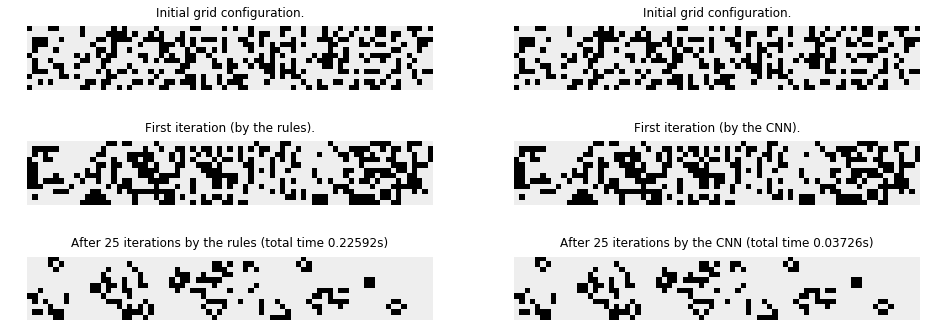

In [11]:
# define the extent of the grids and a color mapping
grid_extent = [0, width, 0, height]
color_map = ListedColormap(['#EEEEEE', '#000000'])

# divide the plot into subplots
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,6))

# draw the grids specified by the printlist,
# for both types of calculation (the rules and the CNN)
for row, (title, index) in enumerate(printlist):
    for col, method in enumerate(['rules', 'CNN']):
        ax[row, col].matshow(
            grids[method][index],
            cmap=color_map,
            extent=grid_extent
            )
        ax[row, col].set_title(title.format(method, times[method]))
        ax[row, col].set_axis_off()

plt.show()